<a href="https://colab.research.google.com/github/MittalNeha/Extensive_Vision_AI6/blob/main/Week3_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Write a neural network that can:
1. take 2 inputs:
    

> a. an image from MNIST dataset, and
> 

> b. a random number between 0 and 9

2. and gives two outputs:

> a. the "number" that was represented by the MNIST image, and


> b. the "sum" of this number with the random number that was generated and sent as the input to the network




> 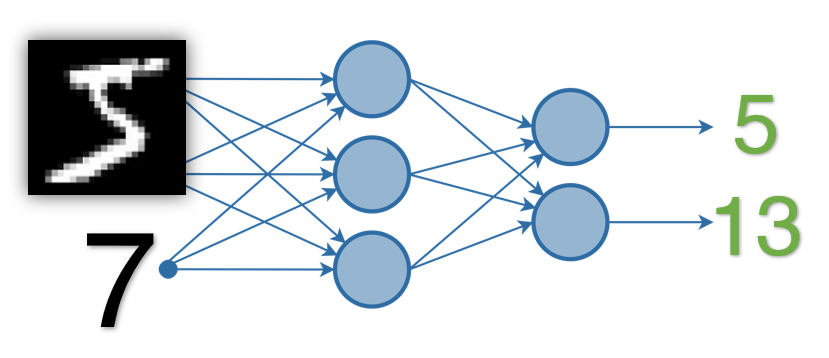



**First lets train MNIST?**

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
# import torch.utils.data.DataLoader

Dataloader

In [2]:
#Load MNIST dataset
from torchvision import datasets

In [3]:
train_set = datasets.MNIST(root='./data/',
                           train=True, 
                           download=True, 
                           transform=transforms.Compose([
                                                         transforms.ToTensor()
                                                         ]))


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


My Network

In [27]:
import torch.nn.functional as F

class MyNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.out_classes = 10

    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)   #3

    #convolution block
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1) #5
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  #7
    self.conv4 = nn.Conv2d(128, 128, 3, padding=1) #11

    self.pool1 = nn.MaxPool2d(2, stride=2)        #22

    self.conv5 = nn.Conv2d(128, 256, 3, padding=1)  
    self.conv6 = nn.Conv2d(256, 256, 3, padding=1)  

    self.pool2 = nn.MaxPool2d(2, stride=2)

    # self.conv6 = nn.Conv2d(128, 256, 3, padding=1) #18
    self.conv7 = nn.Conv2d(256, 512, 3, padding=1) #20
    self.conv8 = nn.Conv2d(512, 512, 3, padding=1)

    self.dense1 = nn.Linear(512 * 7 * 7, 1024)


    # self.conv4 = nn.Conv2d(128, 256, 3, padding=1) #11

    # self.pool1 = nn.MaxPool2d(2, stride=2)        #22

    # self.conv5 = nn.Conv2d(256, 256, 3, padding=1)  
    # self.conv6 = nn.Conv2d(256, 512, 3, padding=1)  

    # self.pool2 = nn.MaxPool2d(2, stride=2)

    # # self.conv6 = nn.Conv2d(128, 256, 3, padding=1) #18
    # self.conv7 = nn.Conv2d(512, 512, 3, padding=1) #20
    # self.conv8 = nn.Conv2d(512, 512, 3, padding=1)

    # self.dense1 = nn.Linear(512 * 7 * 7, 1024)
    self.dense2 = nn.Linear(1024, 10)


  def forward(self, t):

    #input Layer we can add the random number here.
    t = t
    t = self.pool1(F.relu(self.conv4(F.relu(self.conv3(F.relu(self.conv2(F.relu( self.conv1(t) ))))))))

    t = (self.pool2(F.relu(self.conv6(F.relu(self.conv5(t) )))))
    t = self.conv8(F.relu( self.conv7(t) ))

    # t = F.relu(self.conv11
    #     (F.relu
    #      (self.conv10
    #       (F.relu(self.conv9(F.relu( self.conv8(t) )))))))
    
    # t = t.view(t.size(0), -1)
    t = t.view(-1, 7 * 7 * 512)
    t = self.dense2( F.relu( self.dense1(t) ))

    return(F.softmax(t,dim=1))



In [28]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = MyNetwork().to(device)
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
            Conv2d-3          [-1, 128, 28, 28]          73,856
            Conv2d-4          [-1, 128, 28, 28]         147,584
         MaxPool2d-5          [-1, 128, 14, 14]               0
            Conv2d-6          [-1, 256, 14, 14]         295,168
            Conv2d-7          [-1, 256, 14, 14]         590,080
         MaxPool2d-8            [-1, 256, 7, 7]               0
            Conv2d-9            [-1, 512, 7, 7]       1,180,160
           Conv2d-10            [-1, 512, 7, 7]       2,359,808
           Linear-11                 [-1, 1024]      25,691,136
           Linear-12                   [-1, 10]          10,250
Total params: 30,366,858
Trainable params: 30,366,858
Non-trainable params: 0
-------------------------

Train the model

In [29]:
import torch.optim as optim
BATCH_SIZE = 128

def get_corr_pred(pred, truth):

  #Returns the total number of correct predictions
  return pred.argmax(dim=1).eq(truth).sum().item()

def train():
  # torch.set_grad_enabled(True)
  model = MyNetwork().to(device)

  n_train = len(train_set)

  train_dataloader = torch.utils.data.DataLoader(train_set,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               )
  optimizer = optim.Adam(model.parameters(), lr=0.1)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
  # ReduceLROnPlateau

  for epoch in range(10):
    total_loss = 0
    total_correct=0

    for batch in train_dataloader:
      images, labels = batch
      images, labels = images.to(device), labels.to(device)

      preds = model(images)
      loss = F.cross_entropy(preds, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      

      total_loss += loss.item()
      total_correct += get_corr_pred(preds, labels)

    scheduler.step(total_loss/(n_train/BATCH_SIZE))
    print(
        "epoch ", epoch,
        "loss: ",  total_loss/(n_train/BATCH_SIZE), 
        "correct", total_correct,
        "lr: ", scheduler._last_lr,
        
    )

In [30]:
train()

epoch  0 loss:  2.363919613647461 correct 5905 lr:  [0.1]
epoch  1 loss:  2.363802386983236 correct 5918 lr:  [0.1]
epoch  2 loss:  2.3637523869832355 correct 5918 lr:  [0.1]
Epoch     4: reducing learning rate of group 0 to 1.0000e-02.
epoch  3 loss:  2.363780165100098 correct 5918 lr:  [0.010000000000000002]
epoch  4 loss:  2.363774609375 correct 5918 lr:  [0.010000000000000002]
epoch  5 loss:  2.363796831766764 correct 5918 lr:  [0.010000000000000002]
Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
epoch  6 loss:  2.3637579427083333 correct 5918 lr:  [0.0010000000000000002]
epoch  7 loss:  2.3637468317667643 correct 5918 lr:  [0.0010000000000000002]
epoch  8 loss:  2.363791276041667 correct 5918 lr:  [0.0010000000000000002]
Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
epoch  9 loss:  2.3637412760416665 correct 5918 lr:  [0.00010000000000000003]


In [18]:

BATCH_SIZE = 64
model = MyNetwork().to(device)

train_dataloader = torch.utils.data.DataLoader(train_set,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               )
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)


In [ ]:
# torch.set_grad_enabled(True)
# model = MyNetwork().to(device)

# train_dataloader = torch.utils.data.DataLoader(train_set,
#                                                batch_size=BATCH_SIZE,
#                                               #  shuffle=True,
#                                                )
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# for epoch in range(1):
epoch = 0
total_loss = 0
total_correct=0

for batch in train_dataloader:
  # images, labels = next(iter(train_dataloader))
  # targets = F.one_hot(labels)
  images, labels = batch
  # print(labels)
  images, labels = images.to(device), labels.to(device)

  optimizer.zero_grad()
  preds = model(images)
  loss = F.cross_entropy(preds, labels)

  # print(preds.argmax(dim=1))
  
  loss.backward()
  optimizer.step()

  total_loss += loss.item()
  total_correct += get_corr_pred(preds, labels)

  scheduler.step(loss.item())

  print(
    "epoch ", epoch,
    "batch_loss: ", loss.item(),
    # "loss: ",  total_loss, 
    "correct", total_correct,
    "lr: ", scheduler._last_lr,
    "Maybe", optimizer.param_groups[0]['lr']
  )



Total params: 14,334,538


2 blocks
Total params: 14,455,466